### Vector Autoregressions: inflation-unemployment-interest rate

Vector Autoregression (VAR), introduced by Nobel laureate Christopher Sims in 1980, is a powerful statistical tool in the macroeconomist's toolkit.

> Formally a VAR model is
> $$Y_t = A_1 Y_{t-1} + \ldots + A_p Y_{t-p} + u_t$$
> $$u_t \sim {\sf Normal}(0, \Sigma_u)$$
> where $Y_t$ is of dimension $K$ and $A_i$ is a $K \times K$ coefficient matrix.

注意，这里的 $Y_t$ 是多维度的，是多个 y。

In [88]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [89]:
dta = sm.datasets.macrodata.load_pandas().data
endog = dta[["infl", "unemp", "tbilrate"]]

In [90]:
index = sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3')
dta.index = pd.Index(index)
del dta['year']
del dta['quarter']

In [92]:
endog.index = pd.Index(index) # DatetimeIndex or PeriodIndex in 0.8.0
endog.head(10)

,infl,unemp,tbilrate
1959-03-31,0.00,5.8,2.82
1959-06-30,2.34,5.1,3.08
1959-09-30,2.74,5.3,3.82
1959-12-31,0.27,5.6,4.33
1960-03-31,2.31,5.2,3.50
1960-06-30,0.14,5.2,2.68
1960-09-30,2.70,5.6,2.36
1960-12-31,1.21,6.3,2.29
1961-03-31,-0.40,6.8,2.37
1961-06-30,1.47,7.0,2.29


目前的数据是三条时间序列，用于计算 VAR 模型。

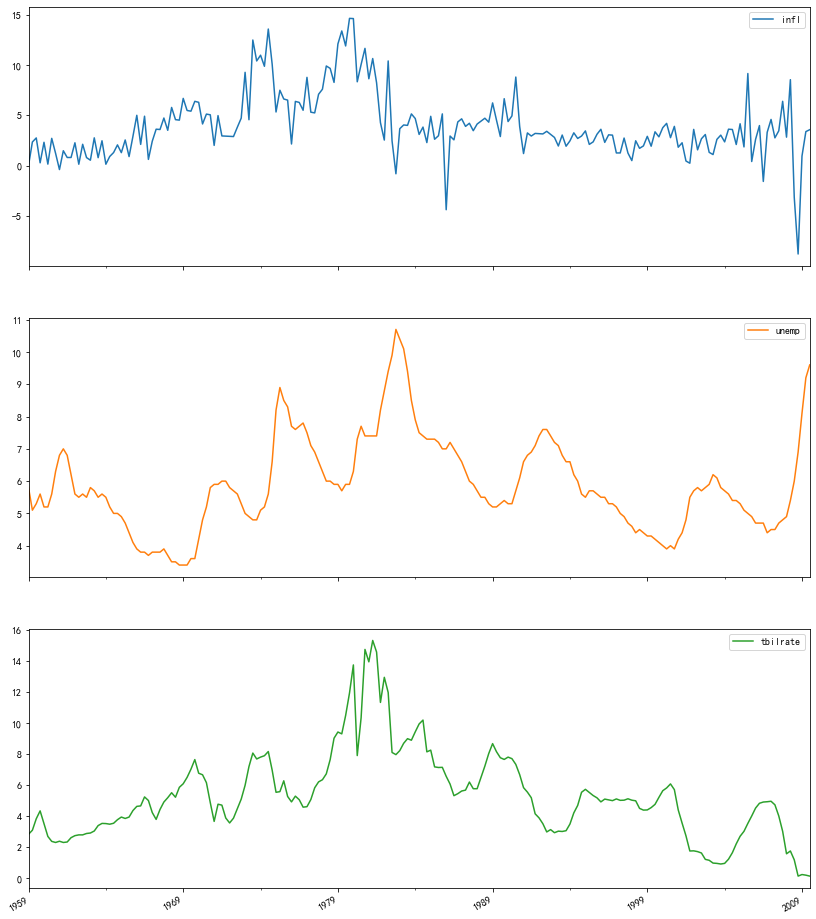

In [34]:
endog.plot(subplots=True, figsize=(14,18));

In [97]:
# model only after Volcker appointment
var_mod = sm.tsa.VAR(endog.loc['1979-12-31':]).fit(maxlags=4, ic=None) # 滞后期只考虑 p <= 4

D:\install\miniconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


In [98]:
var_mod.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 30, Dec, 2019
Time:                     22:23:57
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.38214
Nobs:                     116.000    HQIC:                  -1.93210
Log likelihood:          -320.932    FPE:                  0.0997509
AIC:                     -2.30792    Det(Omega_mle):       0.0725307
--------------------------------------------------------------------
Results for equation infl
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               1.861765         0.975933            1.908           0.056
L1.infl             0.043747         0.099137            0.441           0.659
L1.unemp           -1.772916         1.068556           -1.659       

以上为三个Y变量的搁置的模型结果。

### Diagnostics

In [100]:
np.abs(var_mod.roots)

array([2.78212788, 2.78212788, 1.54716468, 1.54716468, 1.39076945,
       1.39076945, 1.38061045, 1.38061045, 1.139482  , 1.139482  ,
       1.10401958, 1.10401958])

单位根检验通过。

`var_mod.test_normality()` and `var_mod.test_whiteness()` are also available. There are problems with this model...

### Granger-Causality tests

In [112]:
import re

In [133]:
for i in dir(var_mod.test_causality('infl', 'tbilrate', kind = 'Wald')):
    if re.match('_', i) is None:
        print(i)
# 查看有哪些子函数可以看。

caused
causing
conclusion
conclusion_str
crit_value
df
h0
method
pvalue
signif
signif_str
summary
test
test_statistic
title


In [134]:
variables = set(endog.columns.values)

In [135]:
for i in variables:
    for j in variables:
        if i != j:
            print(var_mod.test_causality(i, j, kind = 'Wald').summary())

Granger causality Wald-test. H_0: tbilrate does not Granger-cause infl. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         21.63          9.488   0.000  4
----------------------------------------
Granger causality Wald-test. H_0: unemp does not Granger-cause infl. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         10.50          9.488   0.033  4
----------------------------------------
Granger causality Wald-test. H_0: infl does not Granger-cause tbilrate. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         6.119          9.488   0.190  4
----------------------------------------
Granger causality Wald-test. H_0: unemp does not Granger-cause tbilrate. Conclusion: reject H_0 at 5% significance level.
Test statistic Cri

From this we reject the null that these variables do not Granger cause for all cases except for infl -> tbilrate. In other words, in almost all cases we can reject the null hypothesis that the lags of the *excluded* variable are jointly zero in *Equation*.

### Order Selection

In [85]:
var_mod.model.select_order().summary()

,AIC,BIC,FPE,HQIC
0,3.821,3.895,45.63,3.851
1,-2.693,-2.393,0.06769,-2.571
2,-3.424*,-2.900*,0.03259*,-3.212*
3,-3.335,-2.586,0.03567,-3.031
4,-3.404,-2.429,0.03338,-3.009
5,-3.289,-2.090,0.03754,-2.803
6,-3.239,-1.815,0.03967,-2.661
7,-3.199,-1.550,0.04156,-2.530
8,-3.213,-1.340,0.04131,-2.454
9,-3.255,-1.156,0.04006,-2.404


### Impulse Response Functions

Suppose we want to examine what happens to each of the variables when **a 1 unit increase in the current value of one of the VAR errors occurs (a "shock")**. To isolate the effects of only one error while holding the others constant, we need the model to be in a form so that the contemporaneous errors are uncorrelated across equations. One such way to achieve this is the so-called recursive VAR. In the recursive VAR, the order of the variables is determined by how the econometrician views the economic processes as ocurring. Given this order, 

1. inflation is determined by the contemporaneous unemployment rate and 
1. tbilrate is determined by the contemporaneous inflation and unemployment rates. 
1. Unemployment is a function of only the past values of itself, inflation, and the T-bill rate.

We achieve such a structure by using the Choleski decomposition.

In [86]:
irf = var_mod.irf(24)

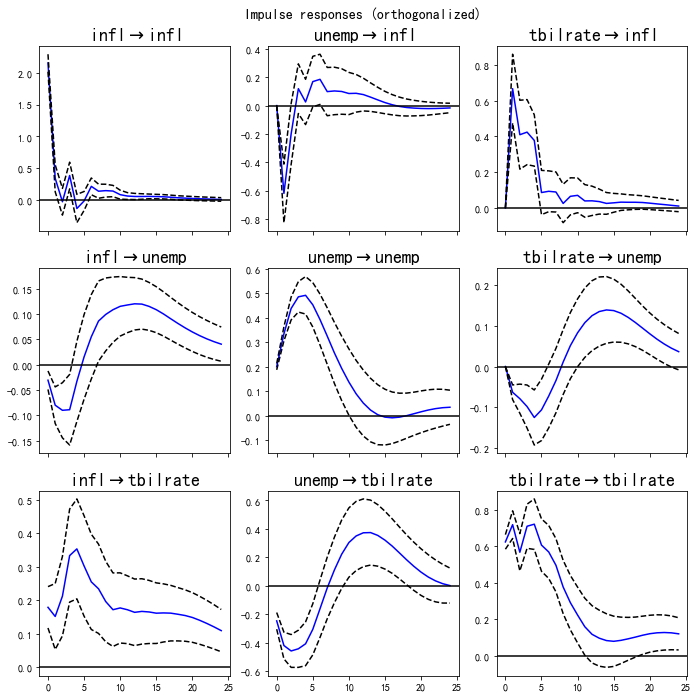

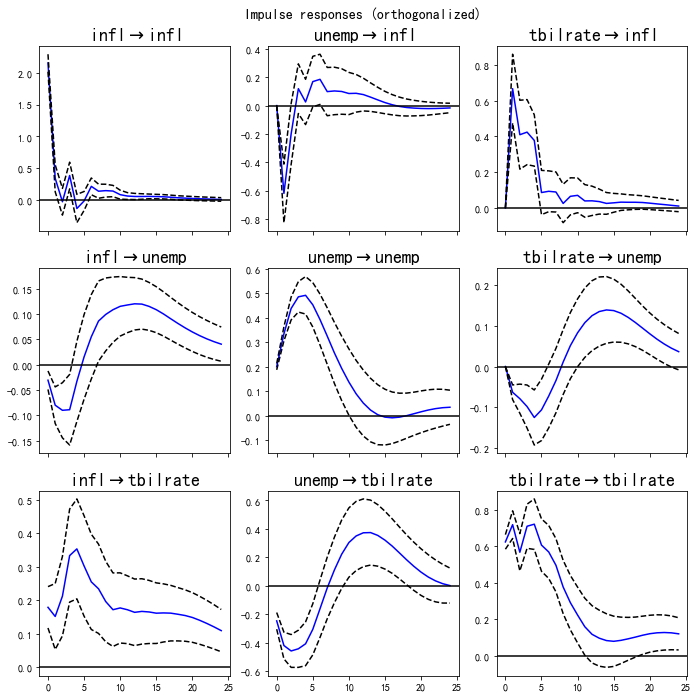

In [87]:
irf.plot(orth=True, signif=.33, subplot_params = {'fontsize' : 18})

Note that inflation dynamics are not very persistent, but do appear to have a significant and immediate impact on interest rates and on unemployment in the medium run.

### Forecast Error Decompositions

In [28]:
var_mod.fevd(24).summary()

FEVD for infl
          infl     unemp  tbilrate
0     1.000000  0.000000  0.000000
1     0.852378  0.068321  0.079300
2     0.821960  0.072742  0.105298
3     0.800366  0.071008  0.128626
4     0.782810  0.069296  0.147895
5     0.778382  0.073392  0.148226
6     0.774765  0.077698  0.147538
7     0.773304  0.078759  0.147937
8     0.772711  0.079996  0.147293
9     0.771720  0.081095  0.147185
10    0.770519  0.081963  0.147518
11    0.769590  0.082942  0.147467
12    0.768802  0.083723  0.147474
13    0.768341  0.084163  0.147496
14    0.768186  0.084338  0.147476
15    0.768135  0.084354  0.147511
16    0.768094  0.084314  0.147592
17    0.768034  0.084282  0.147684
18    0.767934  0.084280  0.147786
19    0.767816  0.084301  0.147883
20    0.767702  0.084342  0.147955
21    0.767601  0.084394  0.148005
22    0.767518  0.084444  0.148038
23    0.767455  0.084490  0.148056

FEVD for unemp
          infl     unemp  tbilrate
0     0.022736  0.977264  0.000000
1     0.044880  0.930399 

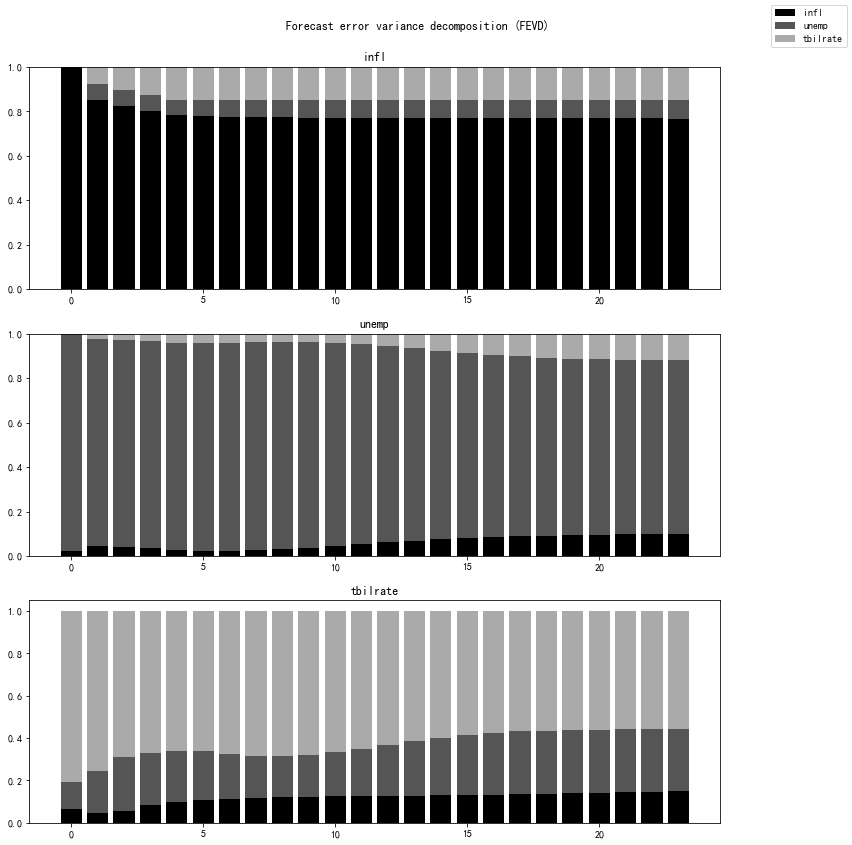

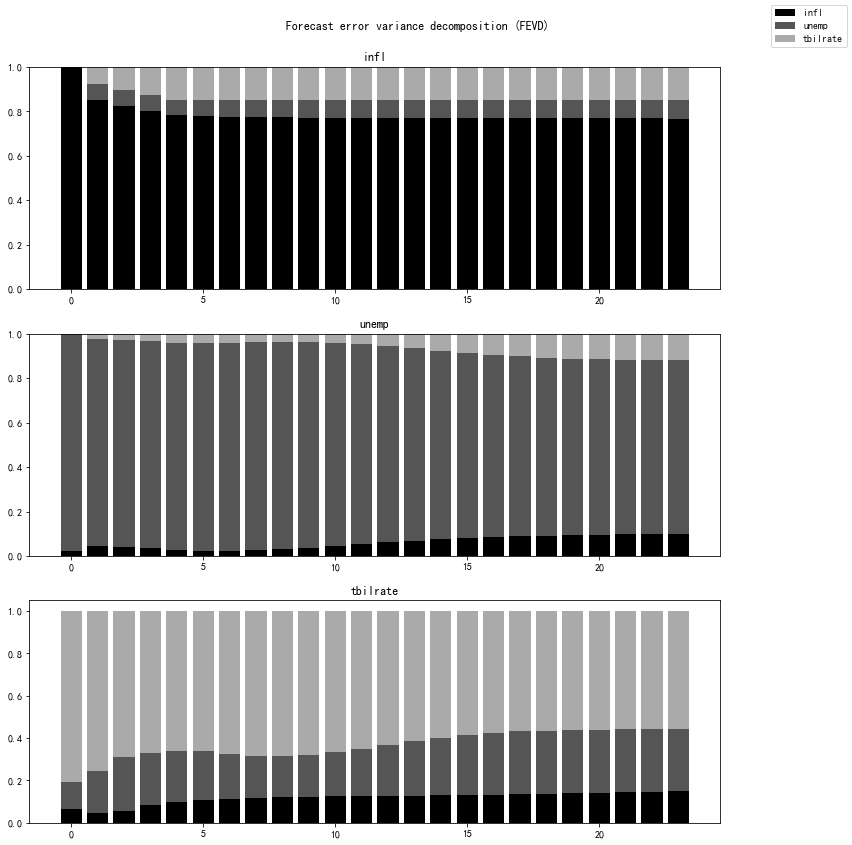

In [29]:
var_mod.fevd(24).plot(figsize=(12,12))

There is some amount of interaction between the variables. For instance, at the 12 quarter horizon, 40% of the error in the forecast of the T-bill rate is attributed to the inflation and unemployment shocks in the recursive VAR.

To make structural inferences - e.g., what is the effect on the rate of inflation and unemployment of an unexpected 100 basis point increase in the Federal Funds rate (proxied by the T-bill rate here), we might want to fit a structural VAR model based on economic theory of monetary policy. For instance, we might replace the VAR equation for the T-bill rate with a policy equation such as a Taylor rule and restrict coefficients. You can do so with the sm.tsa.SVAR class.

### Exercises

Experiment with different VAR models. You can try to adjust the number of lags in the VAR model calculated above or the ordering of the variables and see how it affects the model.

You might also try adding variables to the VAR, say *M1* measure of money supply, or estimating a different model using measures of consumption (realcons), government spending (realgovt), or GDP (realgdp).